# Repair Calibration routine and default settings for new robot

Repairment work to establish normal behavior after installation of new screwdriver and tool-changer

In [1]:
# packages needed for this tutorial
from pathlib import Path

# math and robotics
import numpy as np
import spatialmath as sm
import quaternion
from tqdm.notebook import tqdm, trange

# plotting 
import seaborn as sns
import matplotlib as mpl
import matplotlib.pylab as plt

# simulated robot content and helpers
import hrr_common as hrr_cm
import hrr_cobot_robot as hrr_rob

# ROS
import rospy

# set printing and plotting options    
np.set_printoptions(precision=5, suppress=True)
sns.set_theme('notebook')
%matplotlib notebook

In [2]:
%config Completer.use_jedi = False
def get_hostname_and_IP():
    import socket
    with socket.socket(socket.AF_INET, socket.SOCK_DGRAM) as s:
        s.connect(("8.8.8.8", 80))
        return socket.gethostname(), s.getsockname()[0]

_host, _ip = get_hostname_and_IP()
%env ROS_MASTER_URI=http://localhost:11311
print(f"\t\033[1m\033[4m!!!please check that the IPs below is identical!!!\033[0m"+
      f"\n\thost {_host} has IP {_ip}, which should be identical to",end="\nvs:\t")
%env ROS_IP=$_ip

env: ROS_MASTER_URI=http://localhost:11311
	!!!please check that the IPs below is identical!!!
	host hrrN3511rt2004 has IP 172.22.162.200, which should be identical to
vs:	env: ROS_IP=172.22.162.200


In [3]:
rospy.init_node('restore_old_behavior')

In [4]:
cobot = hrr_rob.HrrCobotControl.from_ros(prefix="/hrr_cobot/")

In [5]:
print(cobot)

Hrr-Cobot state:
FT-data:
current force:	[-25.97992 -21.36621  -4.56152] [N]
current torque:	[ 13.33618 -18.18146  -0.40723] [Nm]
current wrench:	[-26.00335 -21.37021  -4.45737  13.3285  -18.18727  -0.40265] [N,Nm]
=>in contact:	True
---
Robot-data:
q:		[  0.00006   0.00007 -86.35657  -0.00008 -11.77097  84.10527][°]
q_dot:		[0. 0. 0. 0. 0. 0.][rad/s]
tau:		[0. 0. 0. 0. 0. 0.][Nm]
pos:		[ 0.50911 -0.       0.83069][m]
quat:		0.59072 <[-0.40583  0.44989 -0.53287]>
tool-pos:	[ 0.50911 -0.       0.83069][m]
tool-rpy:	[-84.10545  74.58566   0.00026][°]
robot-status:	ready
---


In [6]:
from hrr_cobot_robot import static_scene
scene = static_scene.PoseDataBase()
scene.load_tool_poses()

In [8]:
tmp = sm.SE3(np.load('./rack_positions/1_pickup_A.npy'))
q_test = np.load('./rack_positions/1_pickup_q.npy')
scene.legal_tool_changer_pose(cobot.T_B_E_robot),\
scene.legal_tool_changer_pose(tmp)

ValueError: einstein sum subscripts string contains too many subscripts for operand 1

## check FK data

In [8]:
cobot.T_B_E_robot

   0.9986    0.05174  -0.009876 -0.1832    
  -0.008282 -0.03094  -0.9995   -0.2452    
  -0.05202   0.9982   -0.03046   0.6006    
   0         0         0         1         


In [9]:
cobot.T_B_C_robot

   0.9986    0.05174  -0.009876 -0.1832    
  -0.008282 -0.03094  -0.9995   -0.2452    
  -0.05202   0.9982   -0.03046   0.6006    
   0         0         0         1         


## check commands

In [7]:
cobot.init_sns_vel()

In [ ]:
v_test = np.zeros(6)
for t in trange(200):
    v_test[2] = 1e-2 * np.sin(t/ 200.0 * 2 * np.pi)
    cobot.update(u_cmd=v_test, u_cmd_frame="screwdriver_tip", sleep=True)
cobot.stop()

In [ ]:
v_test = np.zeros(6)
for t in trange(1000):
#     v_test[3] = 5e-2
    v_test[2] = 1e-3
    v_test[3] = 3e-3
    v_test[4] = -3e-3
    v_test[5] = 0.0
    
    cobot.update(u_cmd=v_test, u_cmd_frame="screwdriver_tip", sleep=True)
cobot.stop()

In [ ]:
cobot.T_B_E_robot

In [ ]:
cobot.set_EE_FT_transform()

In [ ]:
R_FT_E = cobot.R_FT_E

In [16]:
q_test = cobot.q_calib.copy()
q_test[0] = np.pi/2.0
cobot.FK(q_test)

   0         1         0         0         
   1         0         0        -0.4359    
   0         0        -1         0.705     
   0         0         0         1         


In [13]:
cobot.goTo(cobot.FK(cobot.q_calib))

[INFO]reached desired goal-pose:
  -1         0         0         0.4359    
   0         1         0         0         
   0         0        -1         0.705     
   0         0         0         1         



## Run calibration routine 

Due to missing collision checking / utilities, we need to run the calibration routine slowly and with care!

In [14]:
data = cobot.collect_calibration_data(gains=(0.5, 0.5, 1.0), v=0.2, N=250)

In [20]:
np.save('test_recording', data)

In [21]:
data = np.load('test_recording.npy', allow_pickle=True)

In [22]:
cobot.R_FT_E, sm.base.rotz(135,"deg")

(array([[-0.70711, -0.70711,  0.     ],
        [ 0.70711, -0.70711,  0.00009],
        [-0.00006,  0.00006,  1.     ]]),
 array([[-0.70711, -0.70711,  0.     ],
        [ 0.70711, -0.70711,  0.     ],
        [ 0.     ,  0.     ,  1.     ]]))

<IPython.core.display.Javascript object>


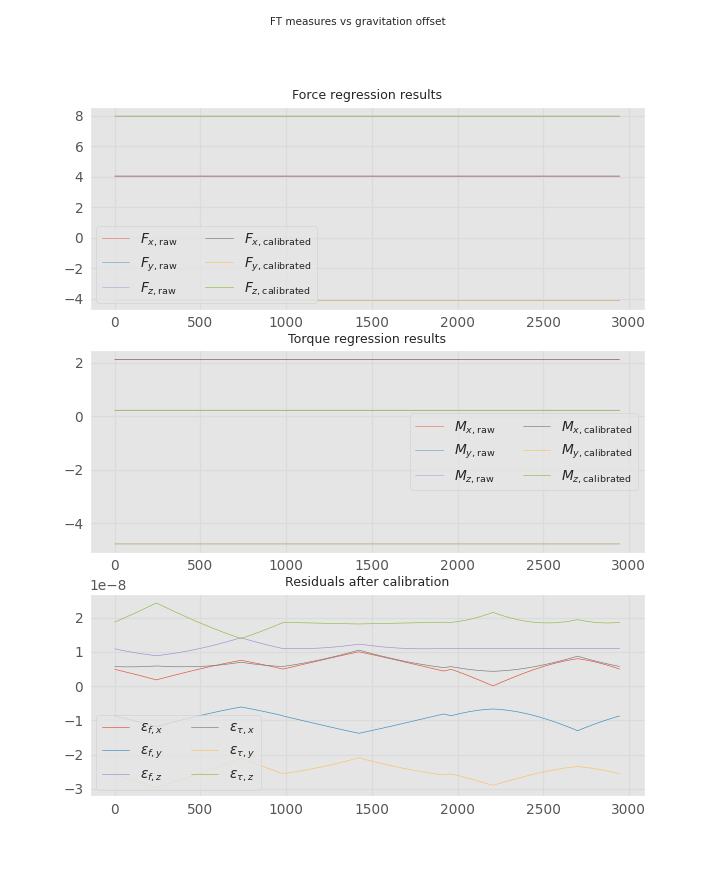

In [15]:
cobot._ft_handle.set_offset(*hrr_rob.ros_interfaces.freespace_offset_regression(data, cobot.R_FT_E, plot=True, call_plot=True))

In [18]:
cobot.update()
cobot.B_F_msr

array([ 0.,  0., -0.,  0.,  0., -0.])

In [16]:
cobot.set_compliant(np.ones(6), K_t=8e-4, K_f=5e-4)

[ERROR]could not initiate compliance using the sensor-track compliance controller


In [19]:
cobot._ft_handle.offset

array([ 4.05396, -4.10889,  7.98926,  2.11975, -4.78088,  0.22058])

## Test screw position data from vision

### Generate dummy offline data from rosbag


generate data array from ROS-bag. Start

```bash
roscd hrr_cobot
cd ../data
rosbag play -l screws.bag
```

check for ros-topic

```ipython
!rostopic list | grep normal
```

then subscribe to topic via 

```python
from hrr_common import PoseArrayData
screws = PoseArrayData("/normals_world_frame")
```

and save data (exclude positions below 40 cm as they are definitely not on the microwave)

```python
np.save('../data/screws/p_sample', screws.positions[screws.positions[..., 2] > 0.4])
np.save('../data/screws/q_sample', screws.quaternions[screws.positions[..., 2] > 0.4])
np.save('../data/screws/R_sample', screws.R_batch[screws.positions[..., 2] > 0.4])
```

## Check for Aruco-Marker (world) -> base link transformation

due to missing collision-checking with screwdriver we drive robot manually close to goal destination

> **WARNING**: The definition of `normals` is currently unclear. The data from CERTH expresses normals as inverted surface normals, thus rather the approaching vector. When testing the data, please set the flag below accordingly.

In [ ]:
p_samples = np.load('../data/screws/p_sample.npy')
q_samples = np.load('../data/screws/q_sample.npy')
R_samples = np.load('../data/screws/R_sample.npy')

### Record robot data from screwdriver in compliance mode

set cobot to compliant and save data

```python
R = RecordData()
```

run as often as needed (once per screw) -> lead to screw head and hold robot at pose

```python
# rospy.sleep(3.0)
for i in trange(1500): 
    cobot.update()
```

save current state

```python
R.save_current()
```

once we are done with recording, we finally save the data 

```python
R.save()
```

In [ ]:
class RecordData:
    
    def __init__(self):
        self.q_record = []
        self.T_B_E_record = []
        self.T_B_C_record = []
        
    def save_current(self):
        self.q_record.append(cobot.q.copy())
        self.T_B_E_record.append(cobot.T_B_E_robot)
        self.T_B_C_record.append(cobot.T_B_C_robot)
        
    def save(self, file_dir=Path("../data/screws/")):
        def _secure_save(f, d):
            path = file_dir / f"{f}.npy"
            if not path.exists():
                np.save(path, d)
            else:
                print(f'skip existing {path}')
        _secure_save("q_record", np.array(self.q_record))
        _secure_save("T_B_E_record", np.array([x.A for x in self.T_B_E_record]))
        _secure_save("T_B_C_record", np.array([x.A for x in self.T_B_C_record]))


### compare with original data

In [ ]:
p_samples = np.load('../data/screws/p_sample.npy')
T_B_C_record = np.load('../data/screws/T_B_C_record.npy')

fig = plt.figure()
ax_v = plt.subplot(3, 1, 1)
ax_v.set_title('vision data')
ax_r = plt.subplot(3, 1, 2)
ax_r.set_title('robot recordings')
ax_vr = plt.subplot(3, 1, 3)
ax_vr.set_title('both with offset')

ax_v.scatter(p_samples[:, 1], p_samples[:, 0], c=p_samples[:, 2])
ax_v.set_xlabel("${}^{w}y$");
ax_v.set_ylabel("${}^{w}x$");

ax_r.scatter(T_B_C_record[:, 1, 3], T_B_C_record[:, 0, 3], c=T_B_C_record[:, 2, 3])
ax_r.set_xlabel("${}^{B}y_{r}$");
ax_r.set_ylabel("${}^{B}x_{r}$");

simple_offset = T_B_C_record[-1, :3, 3] - p_samples[3]
tmp = p_samples + simple_offset
ax_vr.scatter(tmp[:, 1], tmp[:, 0], c=tmp[:, 2])
ax_vr.scatter(T_B_C_record[:, 1, 3], T_B_C_record[:, 0, 3], c=T_B_C_record[:, 2, 3], marker='x', s=55.0)
ax_vr.set_xlabel("${}^{B}y_{r}$");
ax_vr.set_ylabel("${}^{B}x_{r}$");
ax_vr.set_xlim(0.35, 0.65)
ax_vr.set_ylim(0.3, 0.8)
plt.subplots_adjust(wspace=0.7, hspace=1.0)

In [ ]:
T_B_C_record[:, 1, 3], T_B_C_record[:, 0, 3]